In [61]:
!pip install tensorflow

In [62]:
!pip install keras-core --upgrade
!pip install -q keras-nlp
!pip install seaborn
!pip install tensorflow-text==2.15.0
!pip install --upgrade tensorflow-hub
!pip install scikit-learn

In [63]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import keras_core as keras
import keras_nlp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer


# Load the Detect AI Generated Text

In [64]:
DATA_DIR = '/content/drive/MyDrive/llm-detect-ai-generated-text/'

for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/llm-detect-ai-generated-text/train_v2_drcat_02.csv
/content/drive/MyDrive/llm-detect-ai-generated-text/train_essays.csv
/content/drive/MyDrive/llm-detect-ai-generated-text/train_prompts.csv
/content/drive/MyDrive/llm-detect-ai-generated-text/sample_submission.csv
/content/drive/MyDrive/llm-detect-ai-generated-text/test_essays.csv
/content/drive/MyDrive/llm-detect-ai-generated-text/train_essays_MODIFIED.gsheet
/content/drive/MyDrive/llm-detect-ai-generated-text/truncated_training_input.csv
/content/drive/MyDrive/llm-detect-ai-generated-text/truncated_training_input2.csv
/content/drive/MyDrive/llm-detect-ai-generated-text/cleaned_file.csv


In [65]:
PROJECT_DIR = '/content/drive/MyDrive/data/'

for dirname, _, filenames in os.walk(PROJECT_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/data/daigt_full_dataset.csv
/content/drive/MyDrive/data/hewlett/hewlett-n=1000-instruct=False-model=meta-llama-3-8b.csv
/content/drive/MyDrive/data/hewlett/hewlett-n=1000-instruct=False-model=mistral-7b-instruct.csv
/content/drive/MyDrive/data/hewlett/hewlett-n=1000-instruct=True-model=mistral-7b-instruct.csv
/content/drive/MyDrive/data/xsum/xsum-gen-n=5000-model=llama3-8b.csv
/content/drive/MyDrive/data/xsum/xsum-gen-model=mistral-7b-v0.1-n=5000.csv
/content/drive/MyDrive/data/gpt2-essays-only/combined.csv
/content/drive/MyDrive/data/gpt2-essays-only/combined.gsheet
/content/drive/MyDrive/data/adversarial-data/xsum-gen-model-llama3-paraphrased_val_data.csv
/content/drive/MyDrive/data/adversarial-data/hewlett-1000-i-false-mistral-7b-paraphrased_val_data.csv
/content/drive/MyDrive/data/adversarial-data/train_essays-paraphrased_val_data.csv
/content/drive/MyDrive/data/adversarial-data/xsum-gen-model-mistral-paraphrased_val_data.csv
/content/drive/MyDrive/data/CNN-a

# Explore the dataset


In [66]:
os.getcwd()

'/content'

In [67]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
df_train_prompts = pd.read_csv(DATA_DIR + "train_prompts.csv")

**Only two prompts are used in this dataset.**

Let's look at the distribution of text/generated in the training set.

In [70]:
df_train_essays = pd.read_csv("/content/drive/MyDrive/data/daigt_full_dataset.csv")

Text(0.5, 1.0, 'Distribution of Labels')

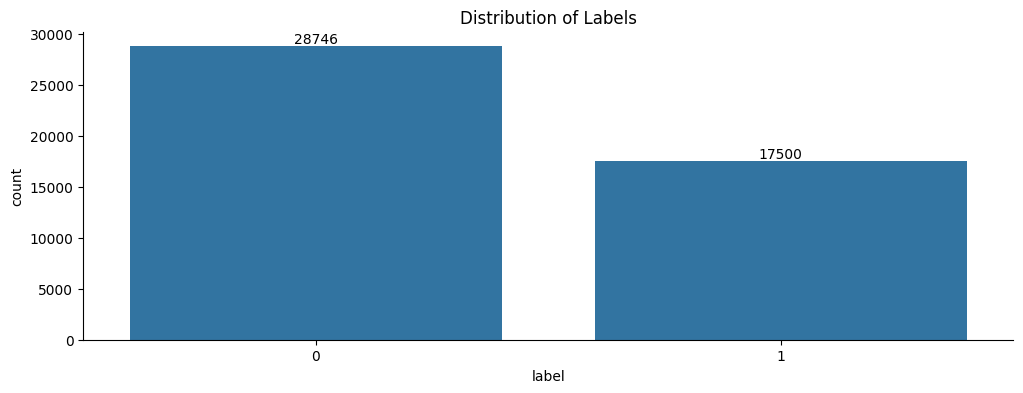

In [71]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays,
                   x="label")

abs_values = df_train_essays['label'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Labels")

In [72]:
df_test_essays = pd.read_csv(PROJECT_DIR + 'CNN-and-Essays-Datasets/CNN Dataset.csv', encoding='utf-8')
df_test_essays.rename(columns={"generated": "label"}, inplace=True)

In [73]:
if "label" not in df_train_essays.columns:
    df_train_essays["label"] = 0

In [103]:
df_train_essays_ext_shuffled = pd.concat([df_train_essays_ext.iloc[:1], df_train_essays_ext.iloc[1:].sample(frac=1, random_state=42)])

df_train_essays_ext_shuffled.reset_index(drop=True, inplace=True)
train_data, test_data = train_test_split(df_train_essays_ext_shuffled.iloc[1:], test_size=0.2, random_state=42)
train_data_with_header = pd.concat([df_train_essays_ext_shuffled.iloc[:1], train_data[["text", "label"]]])
test_data_with_header = pd.concat([df_train_essays_ext_shuffled.iloc[:1], test_data[["text", "label"]]])
train_data_with_header.reset_index(drop=True, inplace=True)
test_data_with_header.reset_index(drop=True, inplace=True)
df_test_essays_final = pd.concat([train_data_with_header[["text", "label"]], df_train_essays[["text", "label"]]])

Text(0.5, 1.0, 'Distribution of Generated Text')

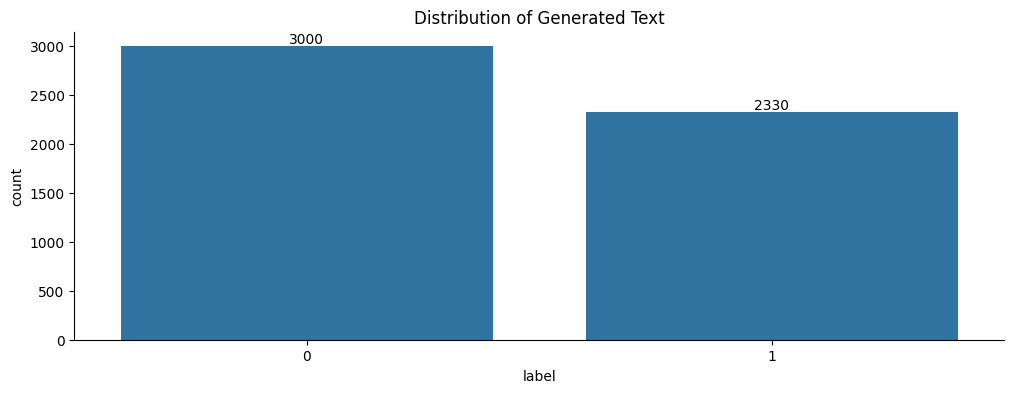

In [104]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_test_essays,
                   x="label")

abs_values = df_test_essays['label'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

In [105]:
df_train_essays["text_length"] = df_train_essays["text"].apply(lambda x : len(x.split()))

In [106]:
from tensorflow.python.keras.optimizers import adam_v2


In [107]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [108]:
SEQ_LENGTH = 512

preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    "distil_bert_base_en_uncased",
    sequence_length=SEQ_LENGTH,
)

classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    "distil_bert_base_en_uncased",
    num_classes=2,
    activation=None,
    preprocessor=preprocessor,
)

classifier.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy()
   ]
)

classifier.backbone.trainable = True


classifier.summary()

/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/backbone.py:101: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/backbone.py:101: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


Preprocessor: "distil_bert_preprocessor_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ distil_bert_backbone (DistilBertBackbone)     │ (None, None, 768)                      │      66,362,880 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ tf.__operators__.getitem_3 (SlicingOpLambda)  │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ pooled_dense (Dense)                          │ (None, 768)                            │         590,592 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ output_dropout (Dropout)                      │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 2)                              │           1,538 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [109]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_test_essays_final["text"],
                                                    df_test_essays_final["label"],
                                                    test_size=0.30,
                                                    random_state=42)

In [110]:
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [111]:
def encode_texts(texts):
    if isinstance(texts, pd.Series):
        texts = texts.tolist()
    elif isinstance(texts, str):
        texts = [texts]

    texts_tensor = tf.convert_to_tensor(texts)
    texts_tensor = tf.cast(texts_tensor, tf.string)

    encoded_texts = use_model(texts_tensor)
    return encoded_texts.numpy()

In [112]:
input_layer = tf.keras.layers.Input(shape=(512,), dtype=tf.float32, name="input_layer")
dropout_layer = tf.keras.layers.Dropout(0.5)(input_layer)
output_layer = tf.keras.layers.Dense(2, activation="softmax", name="output_layer")(dropout_layer)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [113]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [114]:
X_train = X_train.astype(str)
X_test = X_test.astype(str)

X_train_encoded = np.array([encode_texts(text) for text in X_train])
X_test_encoded = np.array([encode_texts(text) for text in X_test])

In [115]:
X_train_encoded = X_train_encoded.reshape((-1, 512))
X_test_encoded = X_test_encoded.reshape((-1, 512))

model.fit(
    x=X_train_encoded,
    y=y_train,
    validation_data=(X_test_encoded, y_test),
    epochs=20,
    batch_size=32
)

Epoch 1/20
1030/1030 [==============================] - 6s 4ms/step - loss: 0.6177 - sparse_categorical_accuracy: 0.6758 - val_loss: 0.5644 - val_sparse_categorical_accuracy: 0.7277
Epoch 2/20
1030/1030 [==============================] - 4s 4ms/step - loss: 0.5314 - sparse_categorical_accuracy: 0.7735 - val_loss: 0.4956 - val_sparse_categorical_accuracy: 0.8209
Epoch 3/20
1030/1030 [==============================] - 4s 4ms/step - loss: 0.4733 - sparse_categorical_accuracy: 0.8323 - val_loss: 0.4460 - val_sparse_categorical_accuracy: 0.8496
Epoch 4/20
1030/1030 [==============================] - 4s 4ms/step - loss: 0.4314 - sparse_categorical_accuracy: 0.8540 - val_loss: 0.4088 - val_sparse_categorical_accuracy: 0.8642
Epoch 5/20
1030/1030 [==============================] - 3s 3ms/step - loss: 0.4003 - sparse_categorical_accuracy: 0.8644 - val_loss: 0.3800 - val_sparse_categorical_accuracy: 0.8761
Epoch 6/20
1030/1030 [==============================] - 4s 4ms/step - loss: 0.3771 - spars

In [116]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Generated","Generated"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))


In [117]:
y_pred_test = model.predict(X_test_encoded)

442/442 [==============================] - 1s 2ms/step


In [118]:
def accuracy_score(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    correct = np.sum(y_true == y_pred)
    total = y_true.size

    return correct / total

y_pred_labels = np.argmax(y_pred_test, axis=1)
test_accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Test set accuracy: {test_accuracy:.4f}")

Test set accuracy: 0.9202


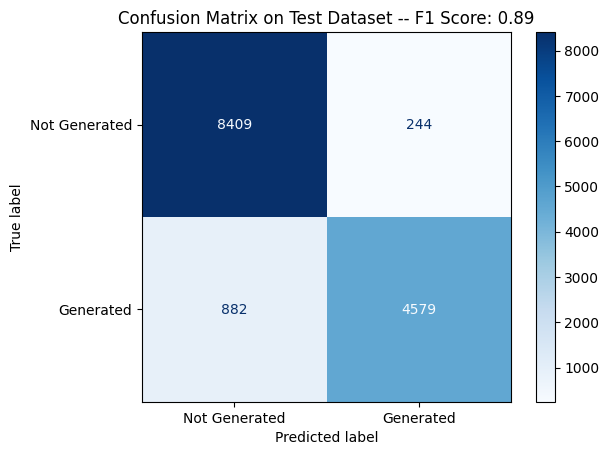

In [119]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
displayConfusionMatrix(y_test, y_pred_test,  "Test")